# **Athens Fine Dining**

## 1.0 Introduction

### 1.1 Descritpion of the case

The area of interest in this porject is the capital of Greece, *Athens*. After a serious fiscal distress due to the global 
economic crisis of 2008-2010, the country of Greece is trying to "rebound" financially and in terms of investments. In this report we aim to utilize and leverage the Foursquare location data in order to evaluate the Food & Drinks (F&D) Sector in the capital of Athens, Greece. The initiative of this project derives from two facts, a) Athens is one of the most prolific tourism capitals in the world [(Source)](https://www.greece-is.com/why-athens-is-becoming-a-top-city-break-destination/), b) there is a distinct trend of new investments [(Source)](https://www.greece-is.com/the-great-promise-of-the-greek-food-and-drinks-industry/) in the F&D sector in order to capitalize the increased levels of tourism traffic. Even though the sector seems to flourish, the segment of “fine-dinning” is considered to be of increased risk as the owners are worried of steady revenues due to the fact that the majority of their clients are tourists and not natives.
Due to data-restrictions and in order to implement the “dimension” of tourism in the case, we enhance our approach through the integration of AirBNB data which will aim to correlate with our findings.

![Athens, Attice Greece](https://image.jimcdn.com/app/cms/image/transf/dimension=1920x400:format=jpg/path/sa6549607c78f5c11/image/idda1a5d403266aac/version/1457281742/image.jpg)



### 1.2 Objectives of the case

We aim to approach the subject through the prism of two objectives:

1.	Evaluate the distribution of “fine-dinning and drinking” initiatives in the city
2.	Provide a clear suggestion towards new investors in order for them to approach any new investment plans in the sector.


## 2.0 Data

### 2.1 Description of the data and how it will be used to solve the problem

The utilized data-sets for the project will be of three origins:

1.	The segmentation of Athens City will come from the following Wiki [page](https://en.wikipedia.org/wiki/Athens_Prefecture)
2.	The Venue Related data will come from the FourSquare API
3.	The identification of the most recent expensive AirBNB places in Athens will come from [Inside AirBNB](http://insideairbnb.com/get-the-data.html)
4. The coordinates of the locations will come from the Open Street Map data base through the implementation of the tool *Nominatim* 

## 3.0 Methodology

#### 3.1 Importing the necessary libraries.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas import DataFrame

import json # library to handle JSON files
import geocoder # import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests 
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import preprocessing
import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap
from geopy.exc import GeocoderTimedOut 
from geopy.geocoders import Nominatim 
import seaborn as sns
print('Libraries imported.')

Libraries imported.


### 3.1 Gather data for Athens Metropolitan Area Municipalities and Communities.

#### 3.1.1 Athen's Municipalities Data.
In order to obtain the various Municipalities in Athens Metropolitan area we request the relevant data available in Wiki

In [2]:
url = 'https://en.wikipedia.org/wiki/Athens_Prefecture'
df_list = pd.read_html(url)
# Selecting the table of interest
df_raw = df_list[1]
df_raw.head()

,Municipality,Seat,Population,Area (km2),Density (/km2),YPES Code
0,Agia Varvara (Αγία Βαρβάρα),Agia Varvara (Αγία Βαρβάρα),30562,2.425,12603,101.0
1,Agia Paraskevi (Αγία Παρασκευή),Agia Paraskevi (Αγία Παρασκευή),59500,7.967,7498,102.0
2,Agioi Anargyroi (Άγιοι Ανάργυροι),Agioi Anargyroi (Άγιοι Ανάργυροι),32957,3.200,10299,104.0
3,Agios Dimitrios (Άγιος Δημήτριος),Brahami (Μπραχάμι),65173,4.949,13169,103.0
4,Aigaleo (Αιγάλεω),Aigaleo (Αιγάλεω),74046,6.450,11480,106.0


#### 3.1.2  Formating Acquired table.
The acquired table has irrelevant information that we do not need, while additionally in order for the data frame to be utilized efficiently, several alterations and modifications need to be performed.

In [9]:
# Drop the column YPES Code and Seat as they are not needed
df_pr = df_raw.drop(["YPES Code", "Seat"], axis=1)

# Delet the parentheses which include the Greek translation of each municipality's name
df_pr["Municipality"] = df_pr["Municipality"].str.replace(r"\(.*?\)", "")

# Change the name of the first column into "Municipality Seat"
df_rnm = df_pr.rename({'Municipality': 'Municipality'}, axis=1)

# Change the 20th entry column of"Municipality" with the correct translation due to  Nominatim conflict
df_rnm["Municipality"]= df_rnm["Municipality"].str.replace("Irakleio", "Iraklio", case = False)

# Drop the final row as it contains the summed up values
df_ath = df_rnm[0:48]
# Final Data Frame
df_ath.head(10)

,Municipality,Population,Area (km2),Density (/km2)
0,Agia Varvara,30562,2.425,12603
1,Agia Paraskevi,59500,7.967,7498
2,Agioi Anargyroi,32957,3.200,10299
3,Agios Dimitrios,65173,4.949,13169
4,Aigaleo,74046,6.450,11480
5,Alimos,38047,5.909,6439
6,Marousi,69470,13.093,5369
7,Argyroupoli,33158,8.228,4030
8,Athens,745514,38.964,19133
9,Chaidari,46276,22.655,2043


#### 3.1.3 Explore the areas data-set

#####   Evaluate the acquired data in terms of min-max population, area.

In [11]:
df_stat = df_ath
df_stat.sort_values(by=['Population'], ascending=False, ignore_index=True).head()

# Sum of values
print ('The overall population of Athens Metropolitan area is {}'.format(df_stat['Population'].sum()))
print ('The overall area in km2 of Athens Metropolitan area is {}'.format(df_stat['Area (km2)'].sum()))

# Mean of Values
print ('The average population of each Municipality Seat in Athens Metropolitan area is {}'.format(round(df_stat['Population'].mean())))
print ('The average area in km2 of each Municipality Seat in Athens Metropolitan area is {}'.format(round(df_stat['Area (km2)'].mean(),2)))

# Min-Max
print ('The Municipality with the lowest population in Athens Metropolitan area is {}with {} residents'.format(df_ath['Municipality'][(df_ath['Population'].idxmin())], df_ath['Population'].min()))
print ('The Municipality with the highest population in Athens Metropolitan area is {}with {} residents'.format(df_ath['Municipality'][(df_ath['Population'].idxmax())], df_ath['Population'].max()))
print ('The Municipality with the smallest area in km2 in Athens Metropolitan area is {}with {}'.format(df_ath['Municipality'][(df_ath['Area (km2)'].idxmin())], df_ath['Area (km2)'].min()))
print ('The Municipality with the largest area in km2 in Athens Metropolitan area is {}with {} '.format(df_ath['Municipality'][(df_ath['Area (km2)'].idxmax())], df_ath['Area (km2)'].max()))

The overall population of Athens Metropolitan area is 2667440
The overall area in km2 of Athens Metropolitan area is 361.3
The average population of each Municipality Seat in Athens Metropolitan area is 55572
The average area in km2 of each Municipality Seat in Athens Metropolitan area is 7.53
The Municipality with the lowest population in Athens Metropolitan area is Penteli with 4829 residents
The Municipality with the highest population in Athens Metropolitan area is Athens with 745514 residents
The Municipality with the smallest area in km2 in Athens Metropolitan area is Nea Chalkidona with 0.8
The Municipality with the largest area in km2 in Athens Metropolitan area is Athens with 38.964 


#####   Plotting the data in order to evaluate their distribution

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


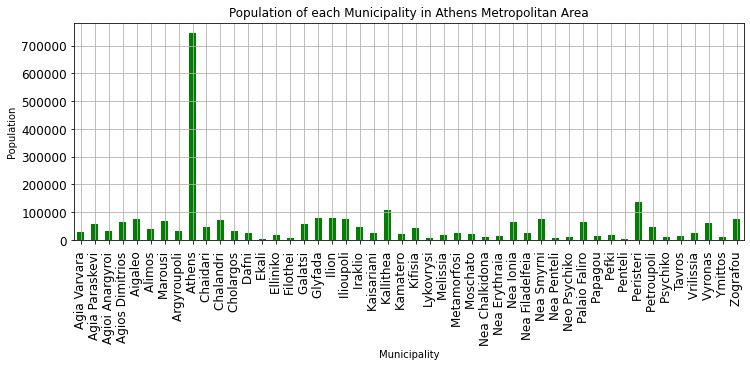

In [13]:
df_stat['Population'].plot(kind='bar', figsize=(12, 4),  rot=90, color='g', fontsize=12)

plt.xlabel('Municipality') # add to x-label to the plot
plt.ylabel('Population') # add y-label to the plot
plt.title('Population of each Municipality in Athens Metropolitan Area') # add title to the plot
plt.axes().set_xticklabels(df_stat['Municipality'])
plt.grid()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


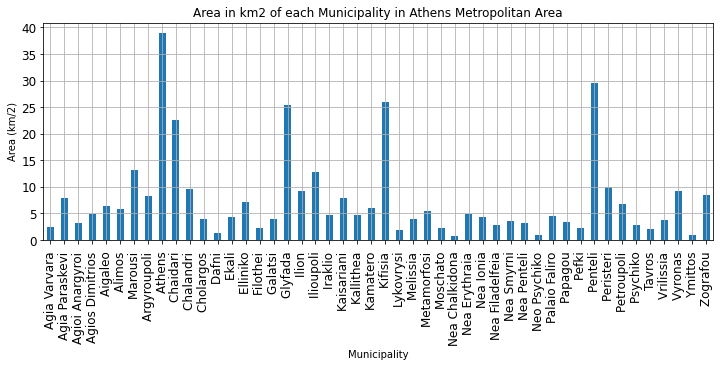

In [14]:
df_stat['Area (km2)'].plot(kind='bar', figsize=(12, 4),  rot=90, fontsize=12)

plt.xlabel('Municipality') # add to x-label to the plot
plt.ylabel('Area (km/2)') # add y-label to the plot
plt.title('Area in km2 of each Municipality in Athens Metropolitan Area') # add title to the plot
plt.axes().set_xticklabels(df_stat['Municipality'])
plt.grid()
plt.show()

It is more than evident, that apart from the municipality of Athens (i.e., Athnes Center), the rest of the other municiplalities illustrate various scales in terms of polulation or area (km2). The next step in order to acquire a more specified idea about the population distribution in the city as also the correlative area of the municipalities is to identify the top-5 of each.

##### Get the top-5 and least-5 in order to have a better look

In [15]:
N = 5 # Number of top ##
# Top- and Least- five in terms of Population
top_pop = df_stat.nlargest(N, ['Population'])
least_pop = df_stat.nsmallest(N, ['Population'])
# Top- and Least- five in terms of Area (km2)
top_area = df_stat.nlargest(N, ['Area (km2)'])
least_area = df_stat.nsmallest(N, ['Area (km2)'])

##### Plot the top-5 and least -5 in order to have a better look

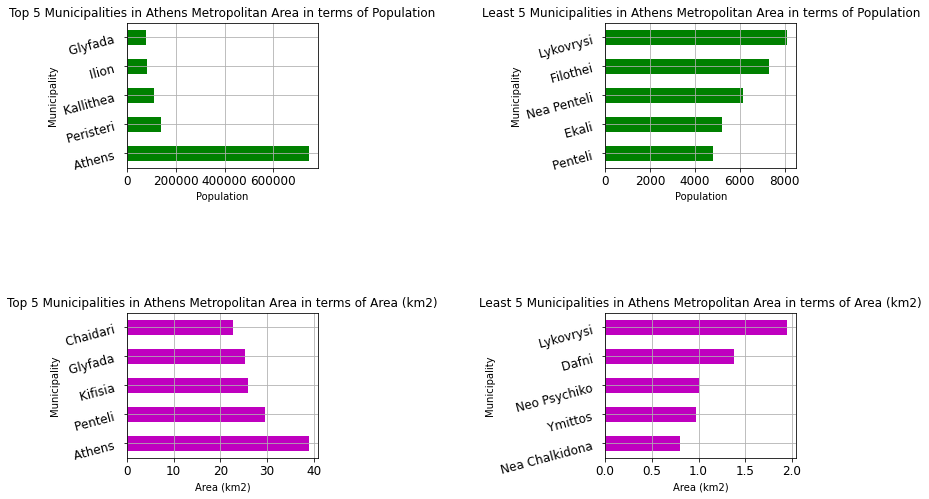

In [16]:
fig = plt.figure(figsize=(12, 8))
plt.subplot(2,2,1)
sub1 = top_pop['Population'].plot(kind='barh',  rot=15, color='g', fontsize=12)
sub1.set_xlabel('Population') # add to x-label to the plot
sub1.set_ylabel('Municipality') # add y-label to the plot
sub1.set_title('Top 5 Municipalities in Athens Metropolitan Area in terms of Population') # add title to the plot
sub1.set_yticklabels(top_pop['Municipality'])
sub1.grid()

plt.subplot(2,2,2)
sub2 = least_pop['Population'].plot(kind='barh',  rot=15, color='g', fontsize=12)
sub2.set_xlabel('Population') # add to x-label to the plot
sub2.set_ylabel('Municipality') # add y-label to the plot
sub2.set_title('Least 5 Municipalities in Athens Metropolitan Area in terms of Population') # add title to the plot
sub2.set_yticklabels(least_pop['Municipality'])
sub2.grid()

plt.subplot(2,2,3)
sub3 = top_area['Area (km2)'].plot(kind='barh',  rot=15, color='m', fontsize=12)
sub3.set_xlabel('Area (km2)') # add to x-label to the plot
sub3.set_ylabel('Municipality') # add y-label to the plot
sub3.set_title('Top 5 Municipalities in Athens Metropolitan Area in terms of Area (km2)') # add title to the plot
sub3.set_yticklabels(top_area['Municipality'])
sub3.grid()

plt.subplot(2,2,4)
sub4 = least_area['Area (km2)'].plot(kind='barh', rot=15, color='m', fontsize=12)
sub4.set_xlabel('Area (km2)') # add to x-label to the plot
sub4.set_ylabel('Municipality') # add y-label to the plot
sub4.set_title('Least 5 Municipalities in Athens Metropolitan Area in terms of Area (km2)') # add title to the plot
sub4.set_yticklabels(least_area['Municipality'])
sub4.grid()

plt.subplots_adjust(hspace = 1, wspace = 1.5)

#### 3.1.4  Get the coordinates of each municipality.

In [17]:
# function to find the coordinate   of a given city  
def findGeocode(area): 
#try and catch is used to overcome the exception thrown by geolocator using geocodertimedout   
    try: # Specify the user_agent as your  app name it should not be none 
        geolocator = Nominatim(user_agent="Athens Fine Dinnig") 
        return geolocator.geocode(area + ',' 'Attica Greece') #Add the search words "Attica Greece" 
    except GeocoderTimedOut: 
        return findGeocode(area)     

In [18]:
# declare an empty list to store latitude and longitude of values of region column 
longitude = [] 
latitude = []     

# each value from city column will be fetched and sent to function find_geocode    
for i in (df_ath["Municipality"]): 
      
    if findGeocode(i) != None: 
           
        loc = findGeocode(i) 
          
# Coordinates returned from function are stored into two separate list 
        latitude.append(loc.latitude) 
        longitude.append(loc.longitude) 
# if coordinate for a city not  found, insert "NaN" indicating missing value  
    else: 
        latitude.append(np.nan) 
        longitude.append(np.nan)                                            

In [21]:
lat_mn = DataFrame (latitude, columns=['Latitude'])
long_mn = DataFrame (longitude, columns=['Longitude'])
ccr_mn = pd.concat([lat_mn, long_mn], axis=1)

In [22]:
df_ath = pd.concat([df_ath, ccr_mn], axis=1)

In [23]:
df_ath.head()

,Municipality,Population,Area (km2),Density (/km2),Latitude,Longitude
0,Agia Varvara,30562,2.425,12603,37.990508,23.659813
1,Agia Paraskevi,59500,7.967,7498,38.006676,23.822694
2,Agioi Anargyroi,32957,3.200,10299,37.965406,23.612490
3,Agios Dimitrios,65173,4.949,13169,37.805011,23.864712
4,Aigaleo,74046,6.450,11480,37.991566,23.681875


#### *Use geopy library to get the latitude and longitude values of Athens.*

In [24]:
address = 'Athens, Attica Greece'

geolocator = Nominatim(user_agent="ath_explorer")
location = geolocator.geocode(address)
ath_latitude = location.latitude
ath_longitude = location.longitude
print('The geograpical coordinates of Athens are {}, {}.'.format(ath_latitude, ath_longitude))

The geograpical coordinates of Athens are 37.9839412, 23.7283052.


#### *Create a map of Athens with neighborhoods superimposed.*

In [25]:
# Create map of Athens using latitude and longitude values
map_ath = folium.Map(location=[ath_latitude, ath_longitude], zoom_start=11)

# Add markers to map
for lat, lng, label in zip(df_ath['Latitude'], df_ath['Longitude'], df_ath['Municipality']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ath)  
    
map_ath

### 3.2 Gather AirBNB data for Athens Metropolitan Area 

#### 3.2.1 Athen's AirBNB Data.
In order to evaluate each neighbordood in Athens in terms of wealth we utilize free AirBNB data from [Inside AirBNB](http://insideairbnb.com/get-the-data.html)

In [26]:
# Read the Athnes CSV with data regarding the "Summary information and metrics for listings in Athens "
df_airBNB = pd.read_csv('listings_Athens.csv')
print (df_airBNB.shape)
df_airBNB.head(5)

(9455, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,10595,"96m2, 3BR, 2BA, Metro, WI-FI etc...",37177,Emmanouil,NaN,ΑΜΠΕΛΟΚΗΠΟΙ,37.98863,23.76527,Entire home/apt,60,2,26,2020-10-06,0.23,6,339
1,10990,Athens Quality Apartments - Deluxe Apartment,37177,Emmanouil,NaN,ΑΜΠΕΛΟΚΗΠΟΙ,37.98903,23.76448,Entire home/apt,36,1,41,2020-09-30,0.41,6,151
2,10993,Athens Quality Apartments - Studio,37177,Emmanouil,NaN,ΑΜΠΕΛΟΚΗΠΟΙ,37.98888,23.76473,Entire home/apt,33,1,52,2020-10-19,0.53,6,274
3,10995,"AQA-No2 1-bedroom, smart tv, fiber connection,",37177,Emmanouil,NaN,ΑΜΠΕΛΟΚΗΠΟΙ,37.98903,23.76448,Entire home/apt,36,1,23,2020-10-03,0.18,6,154
4,27262,"54m2, 1-br, cable tv, wi-fi, metro",37177,Emmanouil,NaN,ΑΜΠΕΛΟΚΗΠΟΙ,37.98924,23.76500,Entire home/apt,38,1,17,2020-01-08,0.17,6,140


As we can see, the new AirBNB data set contains 16 different columns from which we will only utilize the "Neighbourhood, the lats and longs and the pirce tag"

#### 3.2.2 Formating the AirBNB data-set

In [27]:
# Keep only relevant Data
df_airBNB_ath = df_airBNB[['neighbourhood','latitude','longitude', 'price']]
# Change the names of the columns 
df_airBNB_ath = df_airBNB_ath.rename({'neighbourhood': 'Municipality'}, axis=1)
df_airBNB_ath = df_airBNB_ath.rename({'latitude': 'Latitude'}, axis=1)
df_airBNB_ath = df_airBNB_ath.rename({'longitude': 'Longitude'}, axis=1)
df_airBNB_ath = df_airBNB_ath.rename({'price': 'Price'}, axis=1)

#### 3.2.3 Translate the greek entries in "Neighborhood" with created dictionary.

In [29]:
# Create a greek charachter to latin character dictionary.
greek_dict = {
'Α':'A', 'α':'a', 'ά':'a', 'Β':'B', 'β':'b',
'Γ':'G', 'γ':'g', 'Δ':'D', 'δ':'d', 'Ε':'E',
'έ':'e', 'ε':'e', 'Ζ':'Z', 'ζ':'z', 'Η':'I',
'η':'i', 'ή':'i', 'Θ':'TH', 'θ':'TH', 'Ι':'I',
'ι':'i', 'ί':'i', 'Κ':'K', 'κ':'k', 'Λ':'L',
'λ':'l', 'Μ':'M', 'μ':'m', 'Ν':'N', 'ν':'n',
'Ξ':'X', 'ξ':'x', 'Ο':'O', 'ο':'o', 'ό':'o',
'Π':'P', 'π':'p', 'Ρ':'R', 'ρ':'r', 'Σ':'S',
'ς':'s', 'σ':'s', 'Τ':'T', 'τ':'t', 'Υ':'Y',
'ύ':'u', 'υ':'u', 'Φ':'F', 'φ':'f', 'Χ':'CH',
'χ':'CH', 'Ψ':'PS', 'ψ':'PS', 'ω':'o', 'ώ':'o',
'Ω':'O'
}
# creating translate table from dictionary 
trans_table ="ΑαάΒβΓγΔδΕέεΖζΗηήΘθΙιίΚκΛλΜμΝνΞξΟοόΠπΡρΣςσΤτΥύ'υΦφΧχΨψωώΩ".maketrans(greek_dict)
# translating through passed transtable
df_airBNB_ath["Municipality"]= df_airBNB_ath["Municipality"].str.translate(trans_table)
df_airBNB_ath.shape

(9455, 4)

#### 3.2.4 Identify the distribution of Prices among the AirBNB Data.

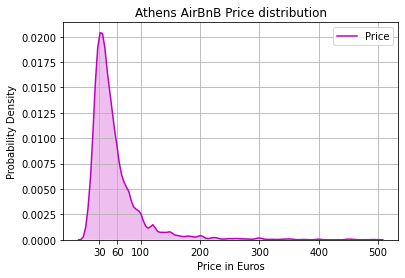

In [30]:
# Price distribution
sns.kdeplot(df_airBNB_ath["Price"],color='m', shade=True, clip=(0, 500))
plt.title("Athens AirBnB Price distribution")
plt.xlabel('Price in Euros') 
plt.ylabel('Probability Density')
plt.xticks([30, 60, 100, 200, 300, 400, 500])
plt.grid()


We see that the most common price range is approximately among 30 and 100 euros. In this step in order to evaluate the areas where the tourists are more likely to spend money in "fine-dinning" venues we will initate the threshold of 70 Euros per night.  

#### 3.2.5 Identify the area of high price appartments.

In [31]:
df_mask = df_airBNB_ath['Price'] > 70
df_airBNB_ath_lux = df_airBNB_ath[df_mask]
df_airBNB_ath_lux.shape
df_airBNB_ath_lux.head(20)

,Municipality,Latitude,Longitude,Price
8,EMPORIKO TRIGONO-PLAKA,37.97692,23.73040,120
15,PLATEIA ATTIKIS,37.99183,23.72980,75
27,PATISIA,38.00876,23.73967,74
32,1O NEKROTAFEIO,37.96101,23.73623,84
33,EMPORIKO TRIGONO-PLAKA,37.97952,23.72367,75
34,ANO PATISIA,38.01719,23.74506,126
41,KOLONAKI,37.97607,23.74075,80
42,EMPORIKO TRIGONO-PLAKA,37.97652,23.72443,141
44,KERAMEIKOS,37.98018,23.72182,72
51,ILISIA,37.97515,23.75387,80


### 3.3 Acquire the venues lists from the FourSquare API

#### 3.3.1  Define Foursquare Credentials and Version.

The free developer plan of the Foursquare API has a default value of venues returned and this needs to be cosnidered as it
may affect the validity of the performed analysis.

In [32]:
CLIENT_ID = 'JRBTADEHZEWDKESG1ZZWHS2ZOYNUL0R2QFZ0TAN2RKYPEVV5' # My Foursquare ID
CLIENT_SECRET = 'YKHIJG0VQMNNDL0VNKKY3FCEXZSPYHP1EZZI520K3OOKWRM4' # My Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
Price = '3,4' # $$$ and more in terms of pricing
CAT_ID = '4d4b7105d754a06374d81259' # Category ID of FOOD
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JRBTADEHZEWDKESG1ZZWHS2ZOYNUL0R2QFZ0TAN2RKYPEVV5
CLIENT_SECRET:YKHIJG0VQMNNDL0VNKKY3FCEXZSPYHP1EZZI520K3OOKWRM4


#### Function to call API in order to get venue related data.
The main goal in this project is to get the venues categorized under the Food & Drink sector. Additioanlly we aim to filter thme in terms of their price tag. Accordint to the FourSquare [link](https://developer.foursquare.com/docs/api-reference/venues/explore/), the price description translates to the following *...Comma separated list of price points. Currently the valid range of price points are [1,2,3,4], 1 being the least expensive, 4 being the most expensive...*. More over, in order to return venues associated with the food industry it is crucial to specify the venue category to food that inculdes a wide list of [subcategories ](https://developer.foursquare.com/docs/build-with-foursquare/categories/).

#### 3.3.2 Venues Explore

In [33]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    print ('Your Client ID is..{}'.format(CLIENT_ID))
    print ('Your Client Secret is a..secret')
    print ('The Foursquare API version utilized is...{}'.format(VERSION))
    print ('The number of venues limit by Foursquare API is...{}'.format(LIMIT))
    print ('The category id of the searched venues is...{} and corresponds to FOOD'.format(CAT_ID))
    print ('The price tag of the searched venues is {}'.format(Price))
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL The extra parameters needed for the search are ll, radius, category id
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryID={}&price={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            CAT_ID,
            Price)
        # make the GET request
        results = requests.get(url).json()
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
   

#### *Get the nearby venues in Athens*

In [34]:
athens_venues = getNearbyVenues(names=df_ath['Municipality'],
                                   latitudes=df_ath['Latitude'],
                                   longitudes=df_ath['Longitude']
                                  )

Your Client ID is..JRBTADEHZEWDKESG1ZZWHS2ZOYNUL0R2QFZ0TAN2RKYPEVV5
Your Client Secret is a..secret
The Foursquare API version utilized is...20180605
The number of venues limit by Foursquare API is...100
The category id of the searched venues is...4d4b7105d754a06374d81259 and corresponds to FOOD
The price tag of the searched venues is 3,4
Agia Varvara 
Agia Paraskevi 
Agioi Anargyroi 
Agios Dimitrios 
Aigaleo 
Alimos 
Marousi 
Argyroupoli 
Athens 
Chaidari 
Chalandri 
Cholargos 
Dafni 
Ekali 
Elliniko 
Filothei 
Galatsi 
Glyfada 
Ilion 
Ilioupoli 
Iraklio 
Kaisariani 
Kallithea 
Kamatero 
Kifisia 
Lykovrysi 
Melissia 
Metamorfosi 
Moschato 
Nea Chalkidona 
Nea Erythraia 
Nea Ionia 
Nea Filadelfeia 
Nea Smyrni 
Nea Penteli 
Neo Psychiko 
Palaio Faliro 
Papagou 
Pefki 
Penteli 
Peristeri 
Petroupoli 
Psychiko 
Tavros 
Vrilissia 
Vyronas 
Ymittos 
Zografou 


#### *Inspect the acquired data frame.*

In [37]:
print(athens_venues.shape)
athens_venues.head(10)

(56, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agios Dimitrios,37.805011,23.864712,Mageta.Co,37.801886,23.865076,Cocktail Bar
1,Aigaleo,37.991566,23.681875,el Presidente,37.993089,23.680599,Cocktail Bar
2,Aigaleo,37.991566,23.681875,αιγαιου γευσεις,37.993375,23.679109,Restaurant
3,Marousi,38.054665,23.808153,Cuba Libre,38.059164,23.808168,Nightclub
4,Argyroupoli,37.905995,23.750387,Despues,37.909254,23.751657,Nightclub
5,Athens,37.983941,23.728305,Point Of View,37.982735,23.725559,Hotel Bar
6,Athens,37.983941,23.728305,Sky Lounge,37.986039,23.730324,Cocktail Bar
7,Athens,37.983941,23.728305,The Cotton Club,37.983241,23.733291,Cocktail Bar
8,Athens,37.983941,23.728305,Delphi,37.984498,23.724615,Hotel Bar
9,Chalandri,38.021520,23.798414,Τζίντζερ,38.020976,23.800485,Cocktail Bar


#####  We see that there is a Venue Category as Cafe and one as a Coffe Shop
 We need to correct them in order to be the same
 

In [38]:
athens_venues["Venue Category"]= athens_venues["Venue Category"].str.replace("Café", "Coffee Shop", case = False)
# Search for each category that containes the tag "...Restaurant..." and replace it with Restaurant
athens_venues["Venue Category"] = athens_venues["Venue Category"].apply(lambda x: 'Restaurant' if 'Restaurant' in x else x)
# Search for each category that containes the tag "...Taverna..." and replace it with Restaurant
athens_venues["Venue Category"] = athens_venues["Venue Category"].apply(lambda x: 'Restaurant' if 'Taverna' in x else x)
athens_venues["Venue Category"] = athens_venues["Venue Category"].apply(lambda x: 'Restaurant' if 'Steakhouse' in x else x)
athens_venues["Venue Category"] = athens_venues["Venue Category"].apply(lambda x: 'Restaurant' if 'BBQ Joint' in x else x)
athens_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agios Dimitrios,37.805011,23.864712,Mageta.Co,37.801886,23.865076,Cocktail Bar
1,Aigaleo,37.991566,23.681875,el Presidente,37.993089,23.680599,Cocktail Bar
2,Aigaleo,37.991566,23.681875,αιγαιου γευσεις,37.993375,23.679109,Restaurant
3,Marousi,38.054665,23.808153,Cuba Libre,38.059164,23.808168,Nightclub
4,Argyroupoli,37.905995,23.750387,Despues,37.909254,23.751657,Nightclub
5,Athens,37.983941,23.728305,Point Of View,37.982735,23.725559,Hotel Bar
6,Athens,37.983941,23.728305,Sky Lounge,37.986039,23.730324,Cocktail Bar
7,Athens,37.983941,23.728305,The Cotton Club,37.983241,23.733291,Cocktail Bar
8,Athens,37.983941,23.728305,Delphi,37.984498,23.724615,Hotel Bar
9,Chalandri,38.021520,23.798414,Τζίντζερ,38.020976,23.800485,Cocktail Bar


#### 3.3.3 Explore the returned venues
#### *How many venues per Venue Category*

Text(0.5, 1.0, 'Number of Venues per Venue Category')

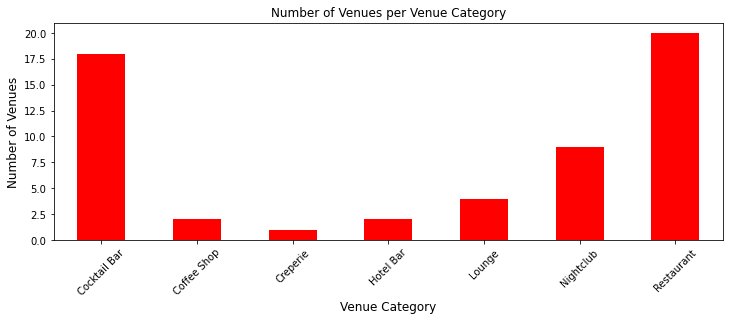

In [39]:
venue_nr = athens_venues.groupby(athens_venues['Venue Category']).count()

venue_nr['Neighborhood'].plot(kind='bar', color='r', figsize=(12, 4),  rot=45)
plt.xlabel('Venue Category', fontsize=12) # add to x-label to the plot
plt.ylabel('Number of Venues' , fontsize=12) # add y-label to the plot
plt.title('Number of Venues per Venue Category') # add title to the plot


#### *How many venues per Municipality Seat*

Text(0.5, 1.0, 'Number of Venues per Municipality')

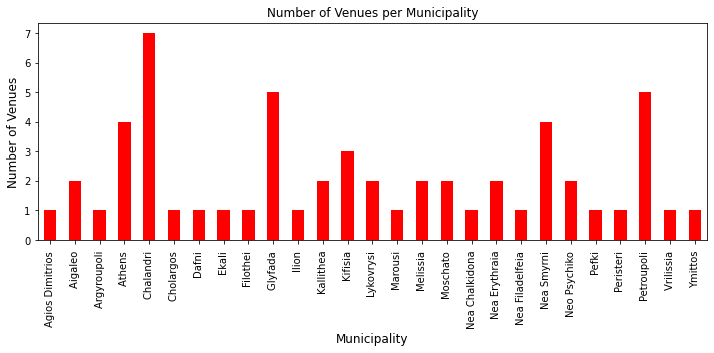

In [40]:
a = athens_venues.groupby('Neighborhood').count()
a['Venue Category'].plot(kind='bar',color='r', figsize=(12, 4))
plt.xlabel('Municipality', fontsize=12) # add to x-label to the plot
plt.ylabel('Number of Venues' , fontsize=12) # add y-label to the plot
plt.title('Number of Venues per Municipality', fontsize=12) # add title to the plot


####  *How many unique categories can be curated from all the returned venues*

In [41]:
print('There are {} uniques categories.'.format(len(athens_venues['Venue Category'].unique())))

There are 7 uniques categories.


#### 3.3.4 Analyze each Municipality

In [42]:
# one hot encoding
athens_onehot = pd.get_dummies(athens_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
athens_onehot['Neighborhood'] = athens_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [athens_onehot.columns[-1]] + list(athens_onehot.columns[:-1])
athens_onehot = athens_onehot[fixed_columns]
print (athens_onehot.shape)
athens_onehot.head(20)


(56, 8)


,Neighborhood,Cocktail Bar,Coffee Shop,Creperie,Hotel Bar,Lounge,Nightclub,Restaurant
0,Agios Dimitrios,1,0,0,0,0,0,0
1,Aigaleo,1,0,0,0,0,0,0
2,Aigaleo,0,0,0,0,0,0,1
3,Marousi,0,0,0,0,0,1,0
4,Argyroupoli,0,0,0,0,0,1,0
5,Athens,0,0,0,1,0,0,0
6,Athens,1,0,0,0,0,0,0
7,Athens,1,0,0,0,0,0,0
8,Athens,0,0,0,1,0,0,0
9,Chalandri,1,0,0,0,0,0,0


####  *Group rows by Municipality and by taking the mean of the frequency of occurrence of each category*

In [43]:
athens_grouped = athens_onehot.groupby('Neighborhood').mean().reset_index()
athens_grouped.shape

(27, 8)

#### *Print each neighborhood along with the top 5 most common venues*

In [44]:
num_top_venues = 5

for hood in athens_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = athens_grouped[athens_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agios Dimitrios ----
          venue  freq
0  Cocktail Bar   1.0
1   Coffee Shop   0.0
2      Creperie   0.0
3     Hotel Bar   0.0
4        Lounge   0.0


----Aigaleo ----
          venue  freq
0  Cocktail Bar   0.5
1    Restaurant   0.5
2   Coffee Shop   0.0
3      Creperie   0.0
4     Hotel Bar   0.0


----Argyroupoli ----
          venue  freq
0     Nightclub   1.0
1  Cocktail Bar   0.0
2   Coffee Shop   0.0
3      Creperie   0.0
4     Hotel Bar   0.0


----Athens ----
          venue  freq
0  Cocktail Bar   0.5
1     Hotel Bar   0.5
2   Coffee Shop   0.0
3      Creperie   0.0
4        Lounge   0.0


----Chalandri ----
          venue  freq
0  Cocktail Bar  0.57
1    Restaurant  0.43
2   Coffee Shop  0.00
3      Creperie  0.00
4     Hotel Bar  0.00


----Cholargos ----
          venue  freq
0  Cocktail Bar   1.0
1   Coffee Shop   0.0
2      Creperie   0.0
3     Hotel Bar   0.0
4        Lounge   0.0


----Dafni ----
          venue  freq
0  Cocktail Bar   1.0
1   Coffee Shop   0.

In [45]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [46]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = athens_grouped['Neighborhood']

for ind in np.arange(athens_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(athens_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Agios Dimitrios,Cocktail Bar,Restaurant,Nightclub
1,Aigaleo,Restaurant,Cocktail Bar,Nightclub
2,Argyroupoli,Nightclub,Restaurant,Lounge
3,Athens,Hotel Bar,Cocktail Bar,Restaurant
4,Chalandri,Cocktail Bar,Restaurant,Nightclub


### 3.4 Predictive Modeling

#### *Run k-means to cluster the neighborhood into clusters.*

In order to utilize the above data manipulation , and apply the desired municipality segmentation we aim to partition the listed venues into groups of areas that have similar characteristics. It is a significant strategy as an investment team can target these specific groups of areas and effectively allocate their resources. 

In [47]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
# set number of clusters
#sum_of_squared_distances = []
distortions = []
sil_score = []
athens_grouped_clustering = athens_grouped.drop('Neighborhood', 1)
K = range(1,12)
for k in K:
    km = KMeans(n_clusters=k, random_state=0, n_init =50, max_iter = 500).fit(athens_grouped_clustering)
    distortions.append(km.inertia_)
    #distortions.append(sum(np.min(cdist(athens_grouped_clustering, km.cluster_centers_, 'euclidean'), axis=1)) / athens_grouped_clustering.shape[0])


 #### *The Elbow Method*
 When the slope of the tangent line starts to be almost horizontal, that is the optimal number of cluster!

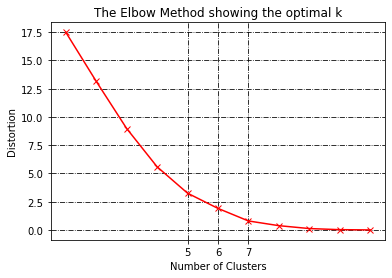

In [48]:
#plt.plot(K, sum_of_squared_distances, 'bx-')
#plt.xlabel('k')
#plt.ylabel('Sum of squared distances')
#plt.title('Elbow Method showing the optimal k')
#plt.show()

plt.plot(K, distortions, 'rx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.xticks([5, 6, 7])
plt.grid(color='k', linestyle='-.')
plt.show()


In [49]:
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(athens_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([5, 2, 1, 2, 2, 5, 5, 4, 4, 2])

####  *Create a new dataframe that include clusters as the top 10 venues for each neighborhood.*

In [50]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head(10)

athens_merged = athens_venues

# merge athens_grouped with athens_data to add latitude/longitude for each neighborhood
athens_merged = athens_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

athens_merged.head() # check the last columns!

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Agios Dimitrios,37.805011,23.864712,Mageta.Co,37.801886,23.865076,Cocktail Bar,5,Cocktail Bar,Restaurant,Nightclub
1,Aigaleo,37.991566,23.681875,el Presidente,37.993089,23.680599,Cocktail Bar,2,Restaurant,Cocktail Bar,Nightclub
2,Aigaleo,37.991566,23.681875,αιγαιου γευσεις,37.993375,23.679109,Restaurant,2,Restaurant,Cocktail Bar,Nightclub
3,Marousi,38.054665,23.808153,Cuba Libre,38.059164,23.808168,Nightclub,1,Nightclub,Restaurant,Lounge
4,Argyroupoli,37.905995,23.750387,Despues,37.909254,23.751657,Nightclub,1,Nightclub,Restaurant,Lounge


####  *Plot the map with the respctive clusters*

In [51]:
from folium.plugins import MarkerCluster
# create map
map_clusters = folium.Map(location=[ath_latitude, ath_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(athens_merged['Venue Latitude'], athens_merged['Venue Longitude'], athens_merged['Neighborhood'], athens_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

#### *Cluster 1*

In [53]:
athens_merged.loc[athens_merged['Cluster Labels'] == 0, athens_merged.columns[[1] + list(range(4, athens_merged.shape[1]))]]

,Neighborhood Latitude,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
31,38.068149,38.068698,23.781926,Lounge,0,Lounge,Restaurant,Nightclub
32,38.068149,38.068455,23.781374,Lounge,0,Lounge,Restaurant,Nightclub
48,38.012811,38.011668,23.694426,Lounge,0,Lounge,Restaurant,Nightclub
55,37.954847,37.954621,23.746249,Lounge,0,Lounge,Restaurant,Nightclub


#### *Cluster 2*

In [54]:
athens_merged.loc[athens_merged['Cluster Labels'] == 1, athens_merged.columns[[1] + list(range(5, athens_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
3,38.054665,23.808168,Nightclub,1,Nightclub,Restaurant,Lounge
4,37.905995,23.751657,Nightclub,1,Nightclub,Restaurant,Lounge
33,38.049186,23.834024,Nightclub,1,Nightclub,Restaurant,Lounge
34,38.049186,23.833959,Nightclub,1,Nightclub,Restaurant,Lounge
37,38.030674,23.735180,Nightclub,1,Nightclub,Restaurant,Lounge
49,38.042469,23.688508,Restaurant,1,Nightclub,Restaurant,Lounge
50,38.042469,23.683437,Nightclub,1,Nightclub,Restaurant,Lounge
51,38.042469,23.687305,Restaurant,1,Nightclub,Restaurant,Lounge
52,38.042469,23.683714,Nightclub,1,Nightclub,Restaurant,Lounge
53,38.042469,23.688178,Nightclub,1,Nightclub,Restaurant,Lounge


#### *Cluster 3*

In [55]:
athens_merged.loc[athens_merged['Cluster Labels'] == 2, athens_merged.columns[[1] + list(range(5, athens_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
1,37.991566,23.680599,Cocktail Bar,2,Restaurant,Cocktail Bar,Nightclub
2,37.991566,23.679109,Restaurant,2,Restaurant,Cocktail Bar,Nightclub
5,37.983941,23.725559,Hotel Bar,2,Hotel Bar,Cocktail Bar,Restaurant
6,37.983941,23.730324,Cocktail Bar,2,Hotel Bar,Cocktail Bar,Restaurant
7,37.983941,23.733291,Cocktail Bar,2,Hotel Bar,Cocktail Bar,Restaurant
8,37.983941,23.724615,Hotel Bar,2,Hotel Bar,Cocktail Bar,Restaurant
9,38.021520,23.800485,Cocktail Bar,2,Cocktail Bar,Restaurant,Nightclub
10,38.021520,23.797355,Restaurant,2,Cocktail Bar,Restaurant,Nightclub
11,38.021520,23.797375,Cocktail Bar,2,Cocktail Bar,Restaurant,Nightclub
12,38.021520,23.797808,Cocktail Bar,2,Cocktail Bar,Restaurant,Nightclub


#### *Cluster 4*

In [56]:
athens_merged.loc[athens_merged['Cluster Labels'] == 3, athens_merged.columns[[1] + list(range(5, athens_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
47,38.059937,23.792229,Coffee Shop,3,Coffee Shop,Restaurant,Nightclub
54,38.039903,23.835151,Coffee Shop,3,Coffee Shop,Restaurant,Nightclub


#### *Cluster 5*

In [57]:
athens_merged.loc[athens_merged['Cluster Labels'] == 4, athens_merged.columns[[1] + list(range(5, athens_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
18,38.106839,23.845494,Restaurant,4,Restaurant,Nightclub,Lounge
19,38.022135,23.789816,Restaurant,4,Restaurant,Nightclub,Lounge
28,38.091527,23.795017,Restaurant,4,Restaurant,Nightclub,Lounge
29,38.091527,23.795721,Restaurant,4,Restaurant,Nightclub,Lounge
30,38.091527,23.795964,Restaurant,4,Restaurant,Nightclub,Lounge
38,38.095511,23.811063,Restaurant,4,Restaurant,Nightclub,Lounge
39,38.095511,23.809669,Restaurant,4,Restaurant,Nightclub,Lounge
40,38.050138,23.742749,Restaurant,4,Restaurant,Nightclub,Lounge


#### *Cluster 6*

In [58]:
athens_merged.loc[athens_merged['Cluster Labels'] == 5, athens_merged.columns[[1] + list(range(5, athens_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,37.805011,23.865076,Cocktail Bar,5,Cocktail Bar,Restaurant,Nightclub
16,38.001805,23.796565,Cocktail Bar,5,Cocktail Bar,Restaurant,Nightclub
17,37.950635,23.737971,Cocktail Bar,5,Cocktail Bar,Restaurant,Nightclub
26,37.956011,23.701938,Cocktail Bar,5,Cocktail Bar,Restaurant,Nightclub
27,37.956011,23.703825,Cocktail Bar,5,Cocktail Bar,Restaurant,Nightclub
45,38.005610,23.777581,Cocktail Bar,5,Cocktail Bar,Restaurant,Nightclub
46,38.005610,23.776696,Cocktail Bar,5,Cocktail Bar,Restaurant,Nightclub


#### *Map illustrating the areas of high piced Airbnb places superimposed on the clustered map*

In [62]:
HeatMap(data=df_airBNB_ath_lux[['Latitude', 'Longitude', 'Price']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=12).add_to(map_clusters)
map_clusters

## 4.0 Results

After the selection of the most optimal cluster number (i.e., k=6), the algorithm provided a data frame with each municipality and the correlative Venue Category, Cluster Label as also the three most common venues in the area.

The following table is listing the corresponding cluster labels and their colors in the map with the respective venue category.


| Cluster Label | Color       | Venue Type                |
|---------------|-------------|---------------------------|
| Cluster 1     | Red         | Lounge                    |
| Cluster 2     | Magenta     | Nightclub / Restaurant    |
| Cluster 3     | Blue        | Cocktail Bar / Restaurant |
| Cluster 4     | Blue -Green | Coffee Shop               |
| Cluster 5     | Green       | Restaurant                |
| Cluster 6     | Orange      | Cocktail Bar              |

Finally, in order to enhance the clustred map, we chose to superimpose the spatial distribution of the most expensive Airbnb choices in the city of Athens. What is interesting to observe is the fact that the majority of the Airbnb places are located in the center of Athens which is completely justified if one considers the fact that the most popular historical and archeological sites are near this area. 


## 5.0 Conclusions and Future Directions

The city of Athens indicates a rather dense grid of areas with increased potential for future investments in the sector of “fine-dining”. According to the municipalities where we locate the most available venues are Chaidari, Glyfada and Petroupoli while the most popular venue types are Restaurants, Nightclub and Cocktail Bars . The parameter of tourism which may be one of the most critical factors in the decision of an investor towards the F&D sector indicates that the best location is the down town center of Athens. Nevertheless, the generated results of our project provide adequate information for the initial planning on an investment in the sector as also a through understanding of the “nature” of each municipality.
The process of identifying the venue categories and the correlative character of the various municipalities in Athens proves to be a robust way that can serve the initial planning of an investment team in order to get the “big picture” of the F&D setting of the city. Due to limitations of the data set as also the return results limit of the FOURSQUARE API we firmly believe that without these restrictions, the process can be enhanced and elevated in terms of precision and result fidelity.